In [2]:
# Agenda
# 1. Implement optimizers - sgd, rmsprop, adam, nadam
# 2. Learn working of wandb
# 3. Adjust code for other hyperparameters
# 4. Create sweeps and wandb

## MA23M002 - ABHINAV T K <br> CS6910 - Assignment 1

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [4]:
# Load the Fashion MNIST dataset
(x, y), (x_test, y_test) = fashion_mnist.load_data()

# Change the shape of the data to (60000, 784)
x = x.reshape(x.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Normalize the data
x = x/255.0
x_test = x_test/255.0

# Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
# Dataset analysis and data preprocessing

# no. of classes
c = len(np.unique(y_train))
print("Total no. of classes = ", c)

# Input features
inp_features = x_train.shape[1]
print("Number of input features = ", inp_features)

# training samples size
m = x_train.shape[0]
print("Training samples = ", m)

# validation samples size
m_val = x_val.shape[0]
print("Validation samples = ", m_val)

# test samples size
m_test = x_test.shape[0]
print("Test samples = ", m_test)

# Class names - the index of the class names corresponds to the class label
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Total no. of classes =  10
Number of input features =  784
Training samples =  54000
Validation samples =  6000
Test samples =  10000


In [6]:
# One hot encoding y
y_train_encoded = np.eye(np.max(y_train) + 1)[y_train].T
y_val_encoded = np.eye(np.max(y_val) + 1)[y_val].T
y_test_encoded = np.eye(np.max(y_test) + 1)[y_test].T


# Neural Network Architecture

In [29]:
# Initializing parameters W and b

def initialize_parameters(nn_layers, weight_init="random"):
  '''
  nn_layers: a list containing the number of neurons of each layer - where each layer no. is the index of the list
  '''
  np.random.seed(32)
  parameters = {}                         # dictionary to hold weights and biases of each layer
  prev_v = {}
  for i in range(1, len(nn_layers)):
    if weight_init == "xavier":
      parameters["W"+str(i)] = np.random.randn(nn_layers[i],nn_layers[i-1])*np.sqrt(2/(nn_layers[i]+nn_layers[i-1]))
    elif weight_init == "random":
      parameters["W"+str(i)] = np.random.randn(nn_layers[i], nn_layers[i-1])
    parameters["b"+str(i)] = np.zeros((nn_layers[i], 1))
    prev_v["W"+str(i)] = np.zeros((nn_layers[i], nn_layers[i-1]))
    prev_v["b"+str(i)] = np.zeros((nn_layers[i], 1))
  return parameters, prev_v

In [8]:
# Defining activation functions and their derivatives

def relu(x):
    return np.maximum(0,x)

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# Derivatives of activation functions

def sigmoid_grad(x):
    return sigmoid(x) * (1-sigmoid(x))

def relu_grad(x):
    return 1*(x>0)

def tanh_grad(x):
    return (1 - (np.tanh(x)**2))

def softmax_grad(x):
    return softmax(x) * (1-softmax(x))

In [9]:
# Forward propagation
def forward_propagation(x, nn_layers, parameters, act_fn):

  l = len(nn_layers)  # 5 # No. of neural network layers, including input and output layers

  a = {}              # dictionary to hold hidden layer (pre-activation)
  h = {}              # dictionary to hold hidden layer (activation)

  h[0] = x.T  # input layer
  #print(h[0].shape)
  for i in range(1, l-1):
    W = parameters["W"+str(i)]        # weights of hidden layer i
    b = parameters["b"+str(i)]        # bias of hidden layer i

    a[i] = np.matmul(W,h[i-1]) + b

    # activation for hidden layers
    if act_fn == 'sigmoid':
      h[i] = sigmoid(a[i])
    elif act_fn == 'relu':
      h[i] = relu(a[i])
    elif act_fn == 'tanh':
      h[i] = tanh(a[i])

  # output layer
  W = parameters["W"+str(l-1)]    # weights of hidden layer i
  b = parameters["b"+str(l-1)]    # bias of hidden layer i

  a[l-1] = np.matmul(W,h[l-2]) + b          # activation function for output layer

  y_hat = softmax(a[l-1])
  return y_hat, h, a                # Returns y_hat, h, a

In [10]:
# Backpropagation
def back_propagation(y_hat, y, h, a, nn_layers, parameters, act_fn, batch_size, l2_reg):
  l = len(nn_layers)
  grads = {}            # dictionary to store gradient of loss function wrt parameters and hidden layer neurons

  # Computing gradient wrt output layer
  grads["grada"+str(l-1)] = y_hat - y

  for i in range(l-1,0,-1):

    grads["gradW" + str(i)] = (1/batch_size)*(np.dot(grads["grada" + str(i)], h[i-1].T) + l2_reg*parameters["W"+str(i)])
    grads["gradb" + str(i)] = (1/batch_size)*np.sum(grads["grada" + str(i)], axis=1, keepdims=True)
    if i>1:
      if act_fn == 'sigmoid':
        grads["grada"+str(i-1)] = np.matmul(parameters["W" + str(i)].T, grads["grada" + str(i)]) * sigmoid_grad(a[i-1])   # Computing gradients wrt hidden layers
      elif act_fn == 'relu':
        grads["grada"+str(i-1)] = np.matmul(parameters["W" + str(i)].T, grads["grada" + str(i)]) * relu_grad(a[i-1])
      elif act_fn == 'tanh':
        grads["grada"+str(i-1)] = np.matmul(parameters["W" + str(i)].T, grads["grada" + str(i)]) * tanh_grad(a[i-1])
  return grads

# Update parameter based on different optimizers

In [11]:
def param_update_sgd(parameters, grads , lr):
    l = len(parameters) // 2    # no. of hidden layers + outer layer
    for i in range(1, l + 1):
        parameters["W" + str(i)] = parameters["W" + str(i)] - lr * grads["gradW" + str(i)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - lr * grads["gradb" + str(i)]
    return parameters

In [12]:
def param_update_momentum(parameters, grads , lr, beta, prev_v):
  l = len(parameters) // 2     # no. of hidden layers + outer layer
  eta = 1.0
  for i in range(1, l + 1):
    prev_v["W"+str(i)] = beta*prev_v["W"+str(i)] + eta*grads["gradW" + str(i)]
    prev_v["b"+str(i)] = beta*prev_v["b"+str(i)] + eta*grads["gradb" + str(i)]

    parameters["W" + str(i)] = parameters["W" + str(i)] - lr*prev_v["W"+str(i)]
    parameters["b" + str(i)] = parameters["b" + str(i)] - lr*prev_v["b"+str(i)]

  return parameters, prev_v

In [13]:
def param_update_nesterov(parameters, grads , lr, beta, prev_v):
  l = len(parameters) // 2     # no. of hidden layers + outer layer
  eta = 1.0
  for i in range(1, l + 1):
    prev_v["W"+str(i)] = beta*prev_v["W"+str(i)] + eta*grads["gradW" + str(i)]
    prev_v["b"+str(i)] = beta*prev_v["b"+str(i)] + eta*grads["gradb" + str(i)]

    parameters["W" + str(i)] = parameters["W" + str(i)] - lr*prev_v["W"+str(i)]
    parameters["b" + str(i)] = parameters["b" + str(i)] - lr*prev_v["b"+str(i)]

  return parameters, prev_v

# Compute loss and accuracy

In [14]:
def compute_loss(y, y_hat, batch_size):
  loss_val = (-1/batch_size)*(np.sum(np.multiply(y, np.log(y_hat))))
  return loss_val

In [15]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def prediction_fn(x_test, nn_layers, parameters, act_fn):
  output, _, _ = forward_propagation(x_test, nn_layers, parameters, act_fn)
  y_hat = np.argmax(output, axis=0)
  return y_hat

def evaluate_model(x_train, y_train, x_test, y_test, nn_layers, parameters, act_fn):
  y_train_hat = prediction_fn(x_train, nn_layers, parameters, act_fn)
  y_test_hat = prediction_fn(x_test, nn_layers, parameters, act_fn)

  # Display training and test accuracy
  train_accuracy = round(accuracy_score(y_train, y_train_hat) * 100, 3)
  test_accuracy = round(accuracy_score(y_test, y_test_hat) * 100, 3)

  print(f"Training accuracy: {train_accuracy}%")
  print(f"Test accuracy: {test_accuracy}%")

  # Display classification report for the test set
  print("\nClassification report for the test set:\n")
  print(classification_report(y_test, y_test_hat))

  return y_train_hat, y_test_hat


In [16]:
# Plotting
import matplotlib.pyplot as plt

def plot_loss_curve(training_loss, validation_loss):
    """
    Plot the training and validation loss curves.
    """
    n1 = len(training_loss)
    n2 = len(validation_loss)
    plt.plot(list(range(n1)), training_loss, 'b', label="Training Loss")
    plt.plot(list(range(n2)), validation_loss, 'r', label="Validation Loss")

    # Adding title and labels
    plt.title("Training and Validation Loss vs Epochs")
    plt.xlabel("# Epochs")
    plt.ylabel("Loss")

    plt.grid()
    plt.legend()
    plt.show()


# Train the model

In [45]:
def train_model(x_train, y_train, x_val, y_val, epochs = 10, num_hidden_layers = 1, num_neurons = 128, learning_rate = 0.001,
                act_fn = 'sigmoid', weight_init = 'xavier', optimizer = 'sgd',  batch_size = 512, l2_reg = 0):
  '''
  number of epochs: 5, 10
  number of hidden layers: 3, 4, 5
  size of every hidden layer: 32, 64, 128
  weight decay (L2 regularisation): 0, 0.0005, 0.5
  learning rate: 1e-3, 1e-4
  optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
  batch size: 16, 32, 64
  weight initialisation: random, Xavier
  activation functions: sigmoid, tanh, relu
  '''

  nn_layers = [inp_features] + [num_neurons]*num_hidden_layers + [c]
  parameters, prev_v = initialize_parameters(nn_layers, weight_init)
  params_nesterov = parameters.copy()
  l = len(parameters) // 2                              # no. of hidden layers + outer layer
  beta = 0.9                                            # decay rate
  training_loss = []
  validation_loss = []
  for epoch in range(epochs):
    if optimizer == 'sgd':
      batch_size = 1
    for i in range(0, x_train.shape[0], batch_size):
      batch_sz = min(batch_size, x_train.shape[0] - i)
      if optimizer == 'nesterov':
        for j in range(1, l+1):
          params_nesterov["W"+str(j)] = parameters["W"+str(j)] - beta*prev_v["W"+str(j)]
          params_nesterov["b"+str(j)] = parameters["b"+str(j)] - beta*prev_v["b"+str(j)]
        # calculating grads for look ahead
        y_hat, h, a = forward_propagation(x_train[i:i+batch_sz,:], nn_layers, params_nesterov, act_fn)
        grads = back_propagation(y_hat, y_train[:,i:i+batch_sz], h, a, nn_layers, params_nesterov, act_fn, batch_sz, l2_reg)
        # parameter update for nesterove using grad calculated by look ahead
        parameters, prev_v = param_update_momentum(parameters, grads , lr, beta, prev_v)

      else:
        y_hat, h, a = forward_propagation(x_train[i:i+batch_sz,:], nn_layers, parameters, act_fn)
        grads = back_propagation(y_hat, y_train[:,i:i+batch_sz], h, a, nn_layers, parameters, act_fn, batch_sz, l2_reg)
        if optimizer == 'sgd':
          parameters = param_update_sgd(parameters, grads, lr)
        elif optimizer == 'momentum':
          parameters, prev_v = param_update_momentum(parameters, grads , lr, beta, prev_v)

    # model evaluation
    y_hat, _, _ = forward_propagation(x_train, nn_layers, parameters, act_fn)
    cost = compute_loss(y_train, y_hat, 54000)
    training_loss.append(cost)

    #one-hot encoding y_hat
    y_hat_encoded = np.zeros_like(y_hat)
    for i in range(y_hat.shape[1]):
      max_index = np.argmax(y_hat[:, i])
      y_hat_encoded[max_index, i] = 1
    accuracy = np.mean(y_hat_encoded == y_train)

    # loss for the validation set
    y_val_hat, _, _ = forward_propagation(x_val, nn_layers, parameters, act_fn)
    val_cost = compute_loss(y_val, y_val_hat, 6000)
    validation_loss.append(val_cost)
    #one-hot encoding y_val_hat
    y_val_hat_encoded = np.zeros_like(y_val_hat)
    for i in range(y_val_hat.shape[1]):
      max_index = np.argmax(y_val_hat[:, i])
      y_val_hat_encoded[max_index, i] = 1
    val_accuracy = np.mean(y_val_hat_encoded == y_val)

    print("Epochs = ", epoch, "\tTraining cost:", cost, "\tAccuracy:", accuracy, "\t Validation Accuracy:", val_accuracy)

  l1 = [y_train, y_hat, training_loss, y_val, y_val_hat, validation_loss]
  plot_loss_curve(training_loss, validation_loss)
  return l1

Epochs =  0 	Training cost: 1.5622959455755845 	Accuracy: 0.9125407407407408 	 Validation Accuracy: 0.9112333333333333
Epochs =  1 	Training cost: 1.1893250163030973 	Accuracy: 0.9288444444444445 	 Validation Accuracy: 0.9278333333333333
Epochs =  2 	Training cost: 1.0294865624026532 	Accuracy: 0.9365481481481481 	 Validation Accuracy: 0.9342
Epochs =  3 	Training cost: 0.935156306213633 	Accuracy: 0.9412407407407407 	 Validation Accuracy: 0.9385666666666667
Epochs =  4 	Training cost: 0.8698955188361825 	Accuracy: 0.944174074074074 	 Validation Accuracy: 0.9418666666666666


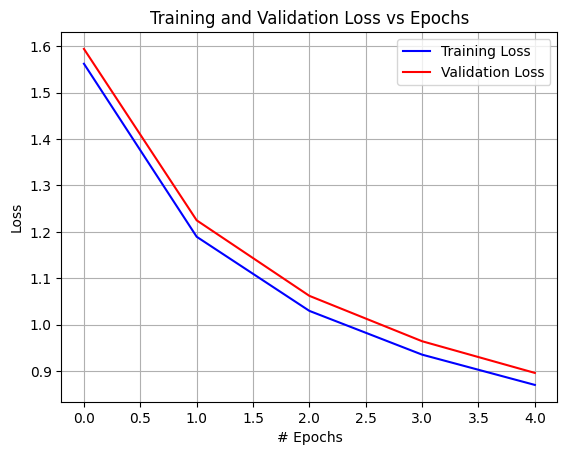

In [50]:
if __name__=='__main__':
  iter = 0
  epochs = 10
  lr = 0.01 # learning rate
  batch_size = 64 #x_train, y_train, x_val, y_val,
  params = train_model(x_train, y_train_encoded, x_val, y_val_encoded, epochs = 5, act_fn = 'sigmoid', optimizer = 'momentum',
                       weight_init = 'random', l2_reg = 0.5)

# Using wandb for hyperparameter tuning

In [ ]:
!pip install wandb

In [20]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [51]:
def run_model_wandb(x_train, y_train, x_val, y_val, epochs = 10, num_hidden_layers = 3, num_neurons = 128, learning_rate = 0.001, act_fn = 'tanh',
                    weight_init = 'random', optimizer = 'momentum',  batch_size = 512, l2_reg = 0):
  '''
  number of epochs: 5, 10
  number of hidden layers: 3, 4, 5
  size of every hidden layer: 32, 64, 128
  weight decay (L2 regularisation): 0, 0.0005, 0.5
  learning rate: 1e-3, 1e-4
  optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
  batch size: 16, 32, 64
  weight initialisation: random, Xavier
  activation functions: sigmoid, tanh, relu
  '''

  nn_layers = [inp_features] + [num_neurons]*num_hidden_layers + [c]
  parameters, prev_v = initialize_parameters(nn_layers, weight_init)
  params_nesterov = parameters.copy()
  l = len(parameters) // 2                              # no. of hidden layers + outer layer
  beta = 0.9                                            # decay rate
  training_loss = []
  validation_loss = []
  for epoch in range(epochs):
    if optimizer == 'sgd':
      batch_size = 1
    for i in range(0, x_train.shape[0], batch_size):
      batch_sz = min(batch_size, x_train.shape[0] - i)
      if optimizer == 'nesterov':
        for j in range(1, l+1):
          params_nesterov["W"+str(j)] = parameters["W"+str(j)] - beta*prev_v["W"+str(j)]
          params_nesterov["b"+str(j)] = parameters["b"+str(j)] - beta*prev_v["b"+str(j)]
        # calculating grads for look ahead
        y_hat, h, a = forward_propagation(x_train[i:i+batch_sz,:], nn_layers, params_nesterov, act_fn)
        grads = back_propagation(y_hat, y_train[:,i:i+batch_sz], h, a, nn_layers, params_nesterov, act_fn, batch_sz, l2_reg)
        # parameter update for nesterove using grad calculated by look ahead
        parameters, prev_v = param_update_momentum(parameters, grads , lr, beta, prev_v)

      else:
        y_hat, h, a = forward_propagation(x_train[i:i+batch_sz,:], nn_layers, parameters, act_fn)
        grads = back_propagation(y_hat, y_train[:,i:i+batch_sz], h, a, nn_layers, parameters, act_fn, batch_sz, l2_reg)
        if optimizer == 'sgd':
          parameters = param_update_sgd(parameters, grads, lr)
        elif optimizer == 'momentum':
          parameters, prev_v = param_update_momentum(parameters, grads , lr, beta, prev_v)

    # model evaluation
    y_hat, _, _ = forward_propagation(x_train, nn_layers, parameters, act_fn)
    cost = compute_loss(y_train, y_hat, 54000)
    training_loss.append(cost)

    #one-hot encoding y_hat
    y_hat_encoded = np.zeros_like(y_hat)
    for i in range(y_hat.shape[1]):
      max_index = np.argmax(y_hat[:, i])
      y_hat_encoded[max_index, i] = 1
    accuracy = np.mean(y_hat_encoded == y_train)
    wandb.log({'train loss': cost, 'train accuracy': accuracy * 100, 'epoch': epoch+1})

    # loss for the validation set
    y_val_hat, _, _ = forward_propagation(x_val, nn_layers, parameters, act_fn)
    val_cost = compute_loss(y_val, y_val_hat, 6000)
    validation_loss.append(val_cost)
    #one-hot encoding y_val_hat
    y_val_hat_encoded = np.zeros_like(y_val_hat)
    for i in range(y_val_hat.shape[1]):
      max_index = np.argmax(y_val_hat[:, i])
      y_val_hat_encoded[max_index, i] = 1
    val_accuracy = np.mean(y_val_hat_encoded == y_val)
    wandb.log({'val_accuracy': val_accuracy * 100})

    print("Epochs = ", epoch, "\tTraining cost:", cost, "\tAccuracy:", accuracy, "\t Validation Accuracy:", val_accuracy)
  #l1 = [y_train, y_hat, training_loss, y_val, y_val_hat, validation_loss]
  #plot_loss_curve(training_loss, validation_loss)
  return parameters

In [52]:
wandb.login(key='4966bf774ea7ce7b47a6e7360b1fad927ece6f1c')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

epochs = 10, num_hidden_layers = 1, num_neurons = 128, learning_rate = 0.001, act_fn = 'sigmoid', weight_init = 'xavier',
                optimizer = 'sgd',  batch_size = 512, wt_decay_l2 = 0 <br>
x_train, y_train, epochs = 10, num_hidden_layers = 3, num_neurons = 128, learning_rate = 0.001, act_fn = 'tanh', weight_init = 'xavier',
                optimizer = 'sgd',  batch_size = 512, wt_decay_l2 = 0

In [53]:
# config file
sweep_config = {
    'method': 'grid',
    'name' : 'sweep dl111',

    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {

        'epochs': {
            'values': [5,10]
        },
        'num_hidden_layers':{
            'values': [3,4,5]
        },
         'num_neurons':{
            'values':[32,64,128]
        },
        'learning_rate':{
            'values':[0.001, 0.0001]
        },
        'act_fn': {
            'values': ['sigmoid','relu', 'tanh']
        },
        'optimizer': {
            'values': ['momentum']
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_init': {
            'values': ['random', 'xavier']
        },
        'l2_reg':{
            'values': [0, 0.0005, 0.5]
        }
    }
}

sweep_id = wandb.sweep(sweep = sweep_config, project='wandb-basics')

Create sweep with ID: n6we5uyl
Sweep URL: https://wandb.ai/abhinavtk/wandb-basics/sweeps/n6we5uyl


In [54]:
def main():
  '''
  WandB calls main function each time with differnet combination.

  We can retrive the same and use the same values for our hypermeters.

  '''

  with wandb.init() as run:
    run_name="-hl_"+str(wandb.config.num_hidden_layers)+"-hs_"+str(wandb.config.num_neurons)+"-ac_"+  \
    wandb.config.act_fn+"-opt_"+wandb.config.optimizer
    wandb.run.name = run_name
    #obj=NN(wandb.config['num_layers'],wandb.config['hidden_size'])
    #hl_3_bs_16_ac_tanh
    iter = 0
    epochs = 10
    lr = 0.01 # learning rate
    batch_size = 64
    params = run_model_wandb(x_train, y_train_encoded, x_val, y_val_encoded)

wandb.agent(sweep_id, function = main, count = 20) # calls main function for count number of times.
wandb.finish()


wandb: Agent Starting Run: 1q83xee1 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: l9ikbgga with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: 0hql5i9w with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: nk4vnv96 with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: zqs4zn5v with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: y2nq7rag with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: p2n75eoa with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: ouj1pk4h with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: ug17o1ul with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: 83mk56uo with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: hsxbraey with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: 6zj4gc4g with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: qr4oomkm with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: 31ukvz2f with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: vuucf5uc with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: 2oriol5d with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: m5yk4b3s with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lb64ln6v with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: 1xadzwhz with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667


wandb: Agent Starting Run: 4inzibbr with config:
wandb: 	act_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epochs =  0 	Training cost: 3.2003514221858738 	Accuracy: 0.9119518518518519 	 Validation Accuracy: 0.91
Epochs =  1 	Training cost: 2.1656509279951854 	Accuracy: 0.9228444444444445 	 Validation Accuracy: 0.9195666666666666
Epochs =  2 	Training cost: 1.6435924684809091 	Accuracy: 0.9277740740740741 	 Validation Accuracy: 0.9221333333333334
Epochs =  3 	Training cost: 1.335223395796518 	Accuracy: 0.9341111111111111 	 Validation Accuracy: 0.9296333333333333
Epochs =  4 	Training cost: 1.189423546142259 	Accuracy: 0.9360740740740741 	 Validation Accuracy: 0.9315666666666667
Epochs =  5 	Training cost: 1.0826888334195868 	Accuracy: 0.9391037037037037 	 Validation Accuracy: 0.9352
Epochs =  6 	Training cost: 1.001908892251492 	Accuracy: 0.9408555555555556 	 Validation Accuracy: 0.9351
Epochs =  7 	Training cost: 0.927766016763525 	Accuracy: 0.9429592592592593 	 Validation Accuracy: 0.938
Epochs =  8 	Training cost: 0.8819533172785067 	Accuracy: 0.9452814814814815 	 Validation Accuracy: 0.9

epoch,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▃▄▆▆▇▇▇██
train loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
epoch,10
train accuracy,94.61741
train loss,0.84072
val_accuracy,93.88667
